## 0- Imports

In [30]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import  torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchsummary  
from sklearn.metrics import accuracy_score
torch.__version__

import gc

In [39]:
def collect_obj(obj):
    del obj
    print(gc.collect())

## 1- Device Configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Very Deep Convolutional Networks for Large-Scale Image Recognition
### Karen Simonyan, Andrew Zisserman (2014). 

## 2- Building VGG16

* For Convulotions and Pooling 
> 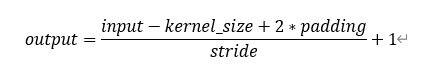

In [69]:
class VGG16(nn.Module): 
    def __init__(self,n_channels=1,n_classes=10):  
        super(VGG16,self).__init__()
        #-- VGG16-C
        #-- in(3,224,224) -normalized images ((R,G,B) - mean(R,G,B))
        #-1- C2d(64,3,3) - C2d(64,3,3) - MP(2,2) #--Conv_MaxPool Stack
        #-2- C2d(128,3,3) - C2d(128,3,3) - MP(2,2) #--Conv_MaxPool Stack  
        #-3- C2d(256,3,3) - C2d(256,3,3) - C2d(256,1,1) - MP(2,2) #--Conv_MaxPool Stack 
        
        #-4- C2d(512,3,3) - C2d(512,3,3) - C2d(512,1,1) - MP(2,2) #--Conv_MaxPool Stack 
        #-5- C2d(512,3,3) - C2d(512,3,3) - C2d(512,1,1) - MP(2,2) #--Conv_MaxPool Stack 
        #-6- FC-1(4096) #--FullyConnected
        #-7- FC-2(4096) #--FullyConnected
        #-8- FC-3(1000) #--Output 1000-Class
        
        self.C11 = nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=(3,3), padding=1, stride=1)
        self.C12 = nn.Conv2d(in_channels = 64, out_channels= 64, kernel_size=(3,3), padding=1, stride=1)

        self.C21 = nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size=(3,3), padding=1, stride=1)
        self.C22 = nn.Conv2d(in_channels = 128, out_channels= 128, kernel_size=(3,3), padding=1, stride=1)

        self.C31 = nn.Conv2d(in_channels = 128, out_channels= 256, kernel_size=(3,3), padding=1, stride=1)
        self.C32 = nn.Conv2d(in_channels = 256, out_channels= 256, kernel_size=(3,3), padding=1, stride=1)
        self.C33 = nn.Conv2d(in_channels = 256, out_channels= 256, kernel_size=(1,1), padding=0, stride=1)
        
        self.C41 = nn.Conv2d(in_channels = 256, out_channels= 512, kernel_size=(3,3), padding=1, stride=1)
        self.C42 = nn.Conv2d(in_channels = 512, out_channels= 512, kernel_size=(3,3), padding=1, stride=1)
        self.C43 = nn.Conv2d(in_channels = 512, out_channels= 512, kernel_size=(1,1), padding=0, stride=1)

        self.C51 = nn.Conv2d(in_channels = 512, out_channels= 512, kernel_size=(3,3), padding=1, stride=1)
        self.C52 = nn.Conv2d(in_channels = 512, out_channels= 512, kernel_size=(3,3), padding=1, stride=1)
        self.C53 = nn.Conv2d(in_channels = 512, out_channels= 512, kernel_size=(1,1), padding=0, stride=1)
        
        #-- classifier
        self.FC1 = nn.Linear(in_features=25088,out_features=4096)
        self.FC2 = nn.Linear(in_features=4096,out_features=4096)
        self.FC3 = nn.Linear(in_features=4096,out_features=1000)

#         #-- classifier (adapted to FashionMnist)
#         self.FC1 = nn.Linear(in_features=32768,out_features=256)
#         self.FC2 = nn.Linear(in_features=256,out_features=10)
        
        self.MP = nn.MaxPool2d(kernel_size=(2,2), padding=0, stride=2)
        #-- ReLU


    def forward(self, x):
        h = torch.relu(self.C11(x))
        h = torch.relu(self.C12(h))
        h = self.MP(h)
        
        h = torch.relu(self.C21(h))
        h = torch.relu(self.C22(h))
        h = self.MP(h)
        
        h = torch.relu(self.C31(h))
        h = torch.relu(self.C32(h))
        h = torch.relu(self.C33(h))
        h = self.MP(h)
        
        h = torch.relu(self.C41(h))
        h = torch.relu(self.C42(h))
        h = torch.relu(self.C43(h))
        h = self.MP(h)
        
        h = torch.relu(self.C51(h))
        h = torch.relu(self.C52(h))
        h = torch.relu(self.C53(h))
        h = self.MP(h)
        
        h = h.reshape(h.shape[0],-1) #- flatten
        
        h = torch.relu(self.FC1(h))
        h = torch.relu(self.FC2(h))
        h = torch.relu(self.FC3(h))
        #h = self.FC2(h)
        return h

In [63]:
#free memory
collect_obj(model)

21


In [57]:
model(x).shape

torch.Size([1, 32768])

In [71]:
#check
model = VGG16(n_channels = 1, n_classes = 10)
x = torch.randn((1,3,224,224))
torchsummary.summary(model,x);

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 224, 224]        1,792
├─Conv2d: 1-2                            [-1, 64, 224, 224]        36,928
├─MaxPool2d: 1-3                         [-1, 64, 112, 112]        --
├─Conv2d: 1-4                            [-1, 128, 112, 112]       73,856
├─Conv2d: 1-5                            [-1, 128, 112, 112]       147,584
├─MaxPool2d: 1-6                         [-1, 128, 56, 56]         --
├─Conv2d: 1-7                            [-1, 256, 56, 56]         295,168
├─Conv2d: 1-8                            [-1, 256, 56, 56]         590,080
├─Conv2d: 1-9                            [-1, 256, 56, 56]         65,792
├─MaxPool2d: 1-10                        [-1, 256, 28, 28]         --
├─Conv2d: 1-11                           [-1, 512, 28, 28]         1,180,160
├─Conv2d: 1-12                           [-1, 512, 28, 28]         2,359,808
├─Conv2d: 1-13                           

## 3- Hyperparameters

In [ ]:
BATCH_SIZE = 64
INPUT_SHAPE = 784
N_CLASSES = 10
LR = 0.01
N_EPOCHS = 1

## 4- Load Data

In [ ]:
#-- train_data
train_data = datasets.MNIST(root='/dataset',train=True,transform=transforms.ToTensor(),download=True)
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

#-- test_data
test_data = datasets.MNIST(root='/dataset',train=False,transform=transforms.ToTensor(),download=True)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
N_BATCHES = len(train_loader)

In [ ]:
for b,y in train_loader:
    print(b.shape)
    break

torch.Size([64, 1, 28, 28])


## 5- Initialize Network

In [ ]:
model = CNN(n_channels = 1, n_classes = N_CLASSES)
model = model.to(device)
model.modules

<bound method Module.modules of CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)>

## 6- Optimizer, Loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LR)

## 7- Training

In [ ]:
for epoch in range(N_EPOCHS):
    print(f'-- epoch : {epoch} / {N_EPOCHS} --')
    for batch_idx, (data,targets) in enumerate(train_loader):
        #-- data to cuda
        data = data.to(device)
        targets = targets.to(device)

        #-- correct data shape (,784)
        #data = data.reshape(data.shape[0],-1)

        #-- forward
        h = model(data)
        loss = criterion(h,targets)

        #-- backward
        optimizer.zero_grad()
        loss.backward()

        #-- gradient update
        optimizer.step()

        #-- print progress
        if batch_idx % (N_BATCHES//4) == 0:
            print(f'\t-- batch_idx : {batch_idx} / {N_BATCHES},\t loss : {round(loss.item(),5)} --')

-- epoch : 0 / 1 --
	-- batch_idx : 0 / 938,	 loss : 0.2815 --
	-- batch_idx : 234 / 938,	 loss : 0.20092 --
	-- batch_idx : 468 / 938,	 loss : 0.11007 --
	-- batch_idx : 702 / 938,	 loss : 0.15226 --
	-- batch_idx : 936 / 938,	 loss : 0.28987 --


## 8- Validation

In [ ]:
def evaluate_model(dataloader,model):
    #--- mode = evaluation
    model.eval()
    y_pred = []
    y_true = []
    #--- no change to our weights
    with torch.no_grad():
        for data,targets in dataloader:
            #-- data to cuda
            data = data.to(device)
            targets = targets.to(device)

            #-- correct data shape (,784)
            #data = data.reshape(data.shape[0],-1)

            #-- forward
            h = model(data) #--logits (real numbers)
            y_pred.append(h.max(dim=1)[1].numpy()) #-- max logits => prediction indices (~ Predicted Numbers)
            y_true.append(targets.numpy())
    acc = accuracy_score(np.concatenate(y_true),np.concatenate(y_pred))
    print('Accuracy : ', acc)
    
    #-- reset mode = train again
    model.train()
    return acc

* Evaluation on Train Data

In [ ]:
acc = evaluate_model(train_loader,model)

Accuracy :  0.9417166666666666


* Evaluation on Test Data

In [ ]:
evaluate_model(test_loader,model);

Accuracy :  0.9439
